In [2]:

import os
import pandas
os.chdir("../")

# !ls -lrt data/groundtruth

In [132]:
# ls -lrt data/

In [4]:
ls -lrt data/groundtruth/csv

after pyenv init
total 2112
-rw-r--r--@ 1 mrestrepo  staff  362510 Oct 15 08:57 train_big_size_A_B_E_K_WH_WB.csv
-rw-r--r--@ 1 mrestrepo  staff  120371 Oct 15 08:57 test_big_size_A_B_E_K_WH_WB.csv
-rw-r--r--@ 1 mrestrepo  staff   50608 Oct 15 08:57 val_big_size_A_B_E_K_WH_WB.csv
-rw-r--r--@ 1 mrestrepo  staff  120385 Oct 21 15:51 test_big_size_A_B_E_K_WH_WB-fixed-header.csv
-rw-r--r--@ 1 mrestrepo  staff   50622 Oct 21 15:51 val_big_size_A_B_E_K_WH_WB-fixed-header.csv
-rw-r--r--@ 1 mrestrepo  staff  362524 Oct 21 15:51 train_big_size_A_B_E_K_WH_WB-fixed-header.csv


In [134]:
!uv add mistree  # Instalar libreria para calcular minimum spanning tree
import pandas as pd
import numpy as np
from pathlib import Path
GT_BASE = Path("data/groundtruth/csv") 
gt_fnames = ["train_big_size_A_B_E_K_WH_WB-fixed-header.csv", 
             "val_big_size_A_B_E_K_WH_WB-fixed-header.csv", 
             "test_big_size_A_B_E_K_WH_WB-fixed-header.csv"]
gt_parts = []
for fname in gt_fnames: 
    df = pd.read_csv(GT_BASE/ fname)
    df["split"] = fname.split("_")[0]
    df["images"] = df["split"] + "/" + df["images"]
    gt_parts.append(df)

gt_df = pd.concat(gt_parts)

# subsets
#   Virunga: Archivos con nombres de como S_##_##_##_DSC#######.JPG
#   AED: Aerial Elephant Dataset = archivos con nombres de la forma <hexadecimal-largo>.JPG
gt_df['subdataset'] = np.where(gt_df['images'].str.contains('_') , 'Virunga', 'AED') 

gt_df.groupby("split").count()

after pyenv init
Resolved 340 packages in 13ms
Audited 121 packages in 13ms


,images,x_min,y_min,x_max,y_max,labels,subdataset
split,,,,,,,
test,2299,2299,2299,2299,2299,2299,2299
train,6962,6962,6962,6962,6962,6962,6962
val,978,978,978,978,978,978,978


In [139]:
pd.DataFrame(gt_df.groupby(["split", "subdataset"]).count()['labels']).reset_index()

,split,subdataset,labels
0,test,AED,688
1,test,Virunga,1611
2,train,AED,2012
3,train,Virunga,4950
4,val,AED,264
5,val,Virunga,714


In [142]:
pd.DataFrame(
    gt_df.groupby(["subdataset", "labels"]).count()['x_min']
).reset_index().rename(columns={"x_min": "n_annots"})

,subdataset,labels,n_annots
0,AED,6,2964
1,Virunga,1,2722
2,Virunga,2,1509
3,Virunga,3,2370
4,Virunga,4,433
5,Virunga,5,241


In [108]:
# calcular una medida "lineal" del tamaño de una anotación 
# como la longitud L tal que L^2 == area de bounding box
gt_df["annot_size"] = np.sqrt( 
      (gt_df["x_max"] - gt_df["x_min"])
    * (gt_df["y_max"] - gt_df["y_min"])
) 
# calcular centros de las cajas
gt_df["x"] = (gt_df["x_max"] + gt_df["x_min"]) * 0.5
gt_df["y"] = (gt_df["y_max"] + gt_df["y_min"]) * 0.5

num_annots_per_image = gt_df.groupby("images").agg(
    {"labels": "count",
    "annot_size": "median"
    }
).reset_index().rename(
    columns={"labels": "num_labels", "annot_size": "median_annot_size"}
)
num_annots_per_image

,images,num_labels,median_annot_size
0,test/01802f75da35434ab373569fffc1fd65a3417aef.JPG,9,52.497619
1,test/018f5ab5b7516a47ff2ac48a9fc08353b533c30f.JPG,11,39.204592
2,test/02033bf9b6c41f5815072434f8d61707cc8ea1fb.JPG,1,53.851648
3,test/02e306916552df0dfe01fa352590ebb5f2a8b8ab.JPG,4,46.163658
4,test/045f3b931fae913307c1f11512e79ddd891cb3ad.JPG,3,55.181519
...,...,...,...
1292,val/S_11_05_16_DSC01928.JPG,3,51.845926
1293,val/S_11_05_16_DSC01929.JPG,2,57.671168
1294,val/S_11_05_16_DSC01932.JPG,1,65.726707
1295,val/S_11_05_16_DSC01963.JPG,9,70.484041


In [115]:
from mistree import GetMST

img_df = gt_df[gt_df["images"] == "val/S_11_05_16_DSC01963.JPG"]
mis = GetMST(x=img_df["x"].values, y=img_df["y"].values)
mis.get_stats(k_neighbours=len(img_df) - 1)

median_edge_len = np.median(mis.edge_length)
median_edge_len


def calc_median_mis_edge(img_df: pd.DataFrame) -> float: 
    if len(img_df) == 1: 
        return float("inf")  # solo una anotación, esto es lo menos crowded que se puede
    else: 
        mis = GetMST(x=img_df["x"].values, y=img_df["y"].values)
        mis.get_stats(k_neighbours=len(img_df) - 1)
        return np.median(mis.edge_length)

med_mis_edge_len = (
    gt_df.groupby("images")
        .apply(calc_median_mis_edge, include_groups=False)
        .reset_index()
        .rename(columns={0: "median_animal_sep"})
)

stats_by_image = num_annots_per_image.merge(med_mis_edge_len, on="images")
stats_by_image["norm_median_sep"] = stats_by_image["median_animal_sep"] / stats_by_image["median_annot_size"]
stats_by_image = stats_by_image.sort_values("norm_median_sep")
stats_by_image

,images,num_labels,median_annot_size,median_animal_sep,norm_median_sep
364,train/11d4e563d06dfd47459ac2a088bcc179e23c34a4...,3,56.444663,28.780516,0.509889
804,train/L_10_05_16_DSC01530.JPG,2,72.671531,47.628773,0.655398
803,train/L_10_05_16_DSC01529.JPG,2,74.434293,49.307707,0.662433
1043,train/S_09_05_16_DSC00800.JPG,3,33.196385,23.517594,0.708438
899,train/L_11_05_16_DSC01393.JPG,2,46.159143,33.241540,0.720151
...,...,...,...,...,...
761,train/L_10_05_16_DSC01222.JPG,1,42.953463,inf,inf
762,train/L_10_05_16_DSC01223.JPG,1,48.928519,inf,inf
765,train/L_10_05_16_DSC01236.JPG,1,64.093681,inf,inf
755,train/L_10_05_16_DSC01204.JPG,1,57.965507,inf,inf


In [129]:
img_fn = stats_by_image.iloc[0]['images']
img_rows = gt_df[gt_df['images'] == img_fn]
img_rows

,images,x_min,y_min,x_max,y_max,labels,split,annot_size,x,y
5695,train/11d4e563d06dfd47459ac2a088bcc179e23c34a4...,1106,2001,1178,2051,6,train,60.000000,1142.0,2026.0
5696,train/11d4e563d06dfd47459ac2a088bcc179e23c34a4...,1117,2040,1173,2079,6,train,46.733286,1145.0,2059.5
5697,train/11d4e563d06dfd47459ac2a088bcc179e23c34a4...,1111,2056,1170,2110,6,train,56.444663,1140.5,2083.0


In [120]:
from PIL import Image

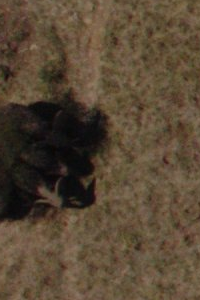

In [131]:
img = Image.open(f"data/{img_fn}") 
img.crop([1100, 1900, 1300, 2200])


### Número único de imágenes

In [105]:
n_unique_images = stats_by_image['images'].nunique()  # de hecho es la misma longitud de la columna 
n_unique_images

1297

In [144]:
# Respuesta a la pregunta cuántas imágenes tienen n anotaciones para cada n = 1, 2, 3,..

num_images_by_n_annots = (
    stats_by_image.groupby("num_labels")
        .agg({
            "images": "count", 
            "norm_median_sep": "mean"
            
        }) 
        .reset_index()
)
num_images_by_n_annots

,num_labels,images,norm_median_sep
0,1,428,inf
1,2,180,23.762492
2,3,105,17.590921
3,4,87,10.403860
4,5,49,10.596737
...,...,...,...
58,96,1,3.329319
59,106,1,3.368512
60,117,1,0.959222
61,118,1,1.013795


In [161]:
def calcular_rango_n_labels(n_labels : int) -> int:
    if n_labels <= 7: return f" {n_labels}"
    elif n_labels <= 10:  
        return f"   (7, 10]"
    elif n_labels <= 15:  
        return f"  (10, 15]"
    elif n_labels <= 20:
        return f"  (15, 20]"
    elif n_labels <= 30:  
        return f"  (20, 30]"
    elif n_labels <= 50:
        return f"  (30, 50]"
    elif n_labels <= 100: 
        return f"  (50, 100]"
    elif n_labels <= 150: 
        return f" (100, 150]"
    else: raise ValueError(f"{n_labels} fuera de todos los rangos")

num_images_by_n_annots[r"Rango \# Anots."] =  num_images_by_n_annots["num_labels"].apply(calcular_rango_n_labels) 

num_images_by_rango_annots = (
    num_images_by_n_annots
        .groupby(r"Rango \# Anots.")
        .agg({
            "images": "sum", 
            "num_labels": "mean",
            "norm_median_sep": "mean"
            }
        )
        .reset_index()
        .sort_values(r"num_labels")
)

num_images_by_rango_annots[r'\% de imágenes'] =  np.round(
    100 *(num_images_by_rango_annots['images'] / n_unique_images), 1
) 
export_df = num_images_by_rango_annots[
    [r"Rango \# Anots.", "images", r"\% de imágenes", "norm_median_sep"]
].copy()
export_df["norm_median_sep"] = np.round(export_df["norm_median_sep"], 1)
export_df


import animaloc_improved.tools.latex_utils as lu

print(lu.df_to_latex(
    export_df,
    caption="Estadisticas de separación entre animales para imagenes categorizadas según "
    "número de anotaciones"
))

export_df

\begin{table}[h!]
\renewcommand{\arraystretch}{1.3}
\centering
\begin{tabular}{c c c c}
\hline
\textbf{Rango \# Anots.} & \textbf{images} & \textbf{\% de imágenes} & \textbf{norm_median_sep}\\
\hline
 1 & 428 & 33.0 & inf\\
 2 & 180 & 13.9 & 23.8\\
 3 & 105 & 8.1 & 17.6\\
 4 & 87 & 6.7 & 10.4\\
 5 & 49 & 3.8 & 10.6\\
 6 & 52 & 4.0 & 7.3\\
 7 & 37 & 2.9 & 6.6\\
   (7, 10] & 76 & 5.9 & 6.2\\
  (10, 15] & 84 & 6.5 & 6.3\\
  (15, 20] & 60 & 4.6 & 5.1\\
  (20, 30] & 69 & 5.3 & 6.2\\
  (30, 50] & 49 & 3.8 & 4.7\\
  (50, 100] & 17 & 1.3 & 4.5\\
 (100, 150] & 4 & 0.3 & 2.2\\
\hline
\end{tabular}
\caption{Estadisticas de separación entre animales para imagenes categorizadas según número de anotaciones}
\end{table}


,Rango \# Anots.,images,\% de imágenes,norm_median_sep
7,1,428,33.0,inf
8,2,180,13.9,23.8
9,3,105,8.1,17.6
10,4,87,6.7,10.4
11,5,49,3.8,10.6
12,6,52,4.0,7.3
13,7,37,2.9,6.6
0,"(7, 10]",76,5.9,6.2
1,"(10, 15]",84,6.5,6.3
2,"(15, 20]",60,4.6,5.1
